In [5]:
import tensorflow as tf
from modules.metropolis import *
import numpy as np
import matplotlib.pyplot as plt

@dataclass
class TestProblem(QFTProblem):
    size: tuple[float, float] = (10, 100)

    def volume(self) -> npt.NDArray:
        return np.array(self.size)

    def get_amplitude(self, x_n: tf.Tensor, ns: npt.NDArray, training: bool = False) -> tf.Tensor:
        mask = tf.sequence_mask(ns, maxlen = x_n.shape[-2])

        mask = tf.cast(mask, x_n.dtype)

        masked_sin = tf.where(mask > 0, tf.sin(x_n[:, :, 0]) * tf.sin(x_n[:, :, 1] / 20), tf.ones_like(x_n[:, :, 0])) # type: ignore

        profile = tf.pow(tf.reduce_prod(masked_sin, axis=1), 2)

        return profile * np.exp(-ns / 10.) / np.power(np.prod(self.volume()), ns / 2.) * (0.1 + ns)

In [ ]:
test_problem = TestProblem()

metropolis = FockSpaceMetropolis(test_problem, 5, rng=np.random.default_rng(0))

x_n, ampilitude = metropolis.new_configuration(2, 2)
print("initial\n", x_n)

x_add = metropolis.add_new(x_n)
print("add new\n", x_add)

x_remove = metropolis.remove_one(x_n)
print("remove one\n", x_remove)
            
x_changed = metropolis.change_positions(x_n)
print("change position\n", x_changed)

x_changed = metropolis.change_positions(x_n)
print("change position\n", x_changed)

x_step, _ = metropolis.step(x_n, ampilitude)
print("step one\n", x_step)
x_n, _ = metropolis.new_configuration(2, 0)
print("initial\n", x_n)

x_remove = metropolis.remove_one(x_n)
print("remove one\n", x_remove)

x_add = metropolis.add_new(x_n)
print("add new\n", x_add)


initial
 ConfigurationBatch(x_n=array([[[ 6.36961687, 26.97867138],
        [ 0.40973524,  1.65276355],
        [ 8.13270239, 91.27555773],
        [ 6.06635776, 72.9496561 ],
        [ 5.43624991, 93.50724238]],

       [[ 8.15853554,  0.27385002],
        [ 8.57404277,  3.35855753],
        [ 7.29655446, 17.56556206],
        [ 8.63178922, 54.14612202],
        [ 2.99711891, 42.26872212]]]), n_s=array([2, 2], dtype=int32))
add new
 ConfigurationBatch(x_n=array([[[ 6.36961687, 26.97867138],
        [ 0.40973524,  1.65276355],
        [ 0.28319671, 12.42832765],
        [ 6.06635776, 72.9496561 ],
        [ 5.43624991, 93.50724238]],

       [[ 8.15853554,  0.27385002],
        [ 8.57404277,  3.35855753],
        [ 6.70624415, 64.71895116],
        [ 8.63178922, 54.14612202],
        [ 2.99711891, 42.26872212]]]), n_s=array([3, 3], dtype=int32))
remove one
 ConfigurationBatch(x_n=array([[[ 6.36961687, 26.97867138],
        [ 0.40973524,  1.65276355],
        [ 8.13270239, 91.27555773],

In [13]:
import modules.metropolis as metro
import importlib
importlib.reload(metro)

test_problem = TestProblem()
test_metropolis = metro.FockSpaceMetropolis(test_problem, 10, rng=np.random.default_rng(0))

x_n, ampilitude = test_metropolis.new_configuration(2, 2)
print("initial\n", x_n)
print("wave", ampilitude)

x_step, ampilitude = test_metropolis.step(x_n, ampilitude)
print("step\n", x_step)
print("wave", ampilitude)

x_step, ampilitude = test_metropolis.step(x_step, ampilitude)
print("step\n", x_step)
print("wave", ampilitude)

x_step, ampilitude = test_metropolis.step(x_step, ampilitude)
print("step\n", x_step)
print("wave", ampilitude)

initial
 ConfigurationBatch(x_n=array([[[ 6.36961687, 26.97867138],
        [ 0.40973524,  1.65276355],
        [ 8.13270239, 91.27555773],
        [ 6.06635776, 72.9496561 ],
        [ 5.43624991, 93.50724238],
        [ 8.15853554,  0.27385002],
        [ 8.57404277,  3.35855753],
        [ 7.29655446, 17.56556206],
        [ 8.63178922, 54.14612202],
        [ 2.99711891, 42.26872212]],

       [[ 0.28319671, 12.42832765],
        [ 6.70624415, 64.71895116],
        [ 6.15385111, 38.36775543],
        [ 9.97209936, 98.08353388],
        [ 6.85541984, 65.04592763],
        [ 6.88446731, 38.8921424 ],
        [ 1.35096505, 72.14883402],
        [ 5.25354322, 31.02418756],
        [ 4.85835359, 88.94878343],
        [ 9.34043516, 35.77951967]]]), n_s=array([2, 2], dtype=int32))
wave tf.Tensor([1.31827694e-08 6.80763163e-08], shape=(2,), dtype=float64)
ratio add [3.71995316e-01 2.63754443e-07]
ratio remove [3.71995316e-07 2.63754443e-13]
ratio vary [3.71995316e-04 2.63754443e-10]
step
 

In [31]:
import modules.metropolis as metro
import importlib
importlib.reload(metro)

test_problem = TestProblem()
test_metropolis = metro.FockSpaceMetropolis(test_problem, 10, rng=np.random.default_rng(0))

def metropolis_step(metropolis: FockSpaceMetropolis, batch = 32, n_init = 5):
    x_recent, amplitude_recent = metropolis.new_configuration(batch, n_init)
    while True:
        x_recent, amplitude_recent = metropolis.step(x_recent, amplitude_recent)
        yield x_recent.x_n, x_recent.n_s

batch = 32
n_max = 10

dataset = tf.data.Dataset.from_generator(
    lambda: metropolis_step(test_metropolis, batch = batch),
    output_signature = (
        tf.TensorSpec(shape=(batch, n_max, 2), dtype=tf.float32, name="features"), # type: ignore
        tf.TensorSpec(shape=(batch), dtype=tf.int32) # type: ignore
    )
)


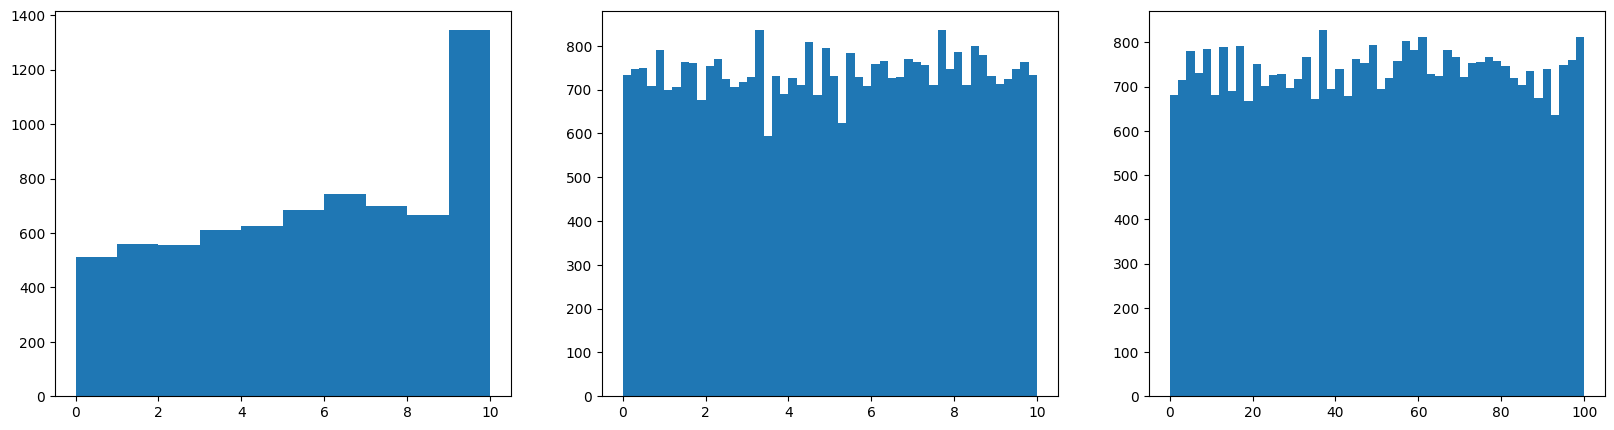

In [32]:
configurations = dataset.unbatch().skip(3000).take(7000).cache()
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

n_values = list(map(lambda x_n: x_n[1], configurations))
axes[0].hist(n_values)

positions_1 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 0], configurations))).ravel()
positions_2 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 1], configurations))).ravel()

axes[1].hist(positions_1, bins=50)
axes[2].hist(positions_2, bins=50);

In [ ]:
with tf.GradientTape() as g2:
    with tf.GradientTape() as g:
        x_n = tf.expand_dims(tf.Variable(configurations[20]), axis=0)
        print(x_n)

        value = test_problem.get_amplitude(x_n)

    gradient = g.gradient(value, x_n)

hessian = g2.jacobian(gradient, x_n)
# laplacian = tf.linalg.trace(laplacian)
laplacian = tf.einsum('bpibpi->bpi', hessian)

print("y", value)
print("gradient", gradient)
print("laplacian", laplacian)

tf.Tensor([[[ 4.85924769 23.90258908]]], shape=(1, 1, 2), dtype=float64)
y tf.Tensor([0.02665474], shape=(1,), dtype=float64)
gradient tf.Tensor([[[-0.00788573  0.00105125]]], shape=(1, 1, 2), dtype=float64)
laplacian tf.Tensor([[[-0.05214298 -0.00011254]]], shape=(1, 1, 2), dtype=float64)


In [ ]:
x0 = 4.85924769
x1 = 23.90258908

print("y", np.power(np.sin(x0) * np.sin(x1 / 20), 2) * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("dy/dx0", np.sin(2 * x0) * np.sin(x1 / 20) ** 2 * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("dy/dx1", 1 / 20 * np.sin(x0) ** 2 * np.sin(2 * x1 / 20) * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("d^2y/dx0^2", 2 * np.cos(2 * x0) * np.sin(x1 / 20) ** 2 * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("d^2y/dx1^2", 1 / 200 * np.sin(x0) ** 2 * np.cos(2 * x1 / 20) * np.exp(-0.1) / np.sqrt(1000) * 1.1)

y 0.026654735548713143
dy/dx0 -0.007885733618981039
dy/dx1 0.0010512547138865212
d^2y/dx0^2 -0.05214298429068455
d^2y/dx1^2 -0.00011254309365187722


In [ ]:
from importlib import reload
import modules.hamiltonians.hamiltonian_terms as terms
reload(terms)

kinetic_term = terms.KineticTerm(0.5)

print(x_n)

print("kinetic term")
print(kinetic_term.local_energy(x_n, test_problem))

chemical_potential = terms.ExternalPotential.chemical_potential(1)

print("Chemical potential")
print(chemical_potential.local_energy(x_n, test_problem))

tf.Tensor([[[ 4.85924769 23.90258908]]], shape=(1, 1, 2), dtype=float64)
kinetic term
tf.Tensor(1.9604594187861322, shape=(), dtype=float64)
Chemical potential
tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
